Este exemplo foi retirado da documentação do módulo scikit-learn (http://scikit-learn.org/stable/modules/ensemble.html#forest)

### Exemplo: Dataset Iris

Este dataset faz parte do conjunto clássico de datasets do repositório UCI Machine Learning (http://archive.ics.uci.edu/ml/datasets/Iris)

Primeiramente, importamos a biblioteca **numpy**, que contém as funções e estruturas de dados próprios para utilização em modelos numéricos (http://www.numpy.org/) No Python, podemos acrescentar um *apelido* à biblioteca importada para que sua posterior utilização seja mais simples. Aqui, chamamos a biblioteca numpy pelo apelido **np**.

In [1]:
import numpy as np

Em seguida, importamos da biblioteca matplotlib o módulo pyplot, apelidado aqui de **plt**, que nos permite fazer gráficos com sintaxe similar à do MATLAB.

In [2]:
import matplotlib.pyplot as plt

Do módulo **datasets** da biblioteca scikit-learn, importamos a função que permite carregarmos o dataset iris.

In [3]:
from sklearn.datasets import load_iris
# Load data
iris = load_iris()

Definimos alguns parâmetros

In [4]:
n_classes = 3
n_estimators = 30
RANDOM_SEED = 13  # fix the seed on each iteration

Importamos e definimos os modelos que nos interessam:

In [5]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

Cada um destes modelos é chamado com a seguinte sintaxe:

*nome-do-modelo = Classificador(args)* : criar o objeto com os parâmetros e métodos específicos a este classificador

*nome-do-modelo.fit( )* : criar as árvores (no caso do random forest) - treinamento.

*nome-do-modelo.predict( )* : aplicar as árvores ao conjunto de dados novos e efetivamente classificá-los

*nome-do-modelo.score( )* : cross-validation score

Agora, vamos definir alguns parâmetros relacionados aos gráficos:

In [6]:
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
plot_idx = 1

O procedimento principal abaixo percorre então as features do dataset duas a duas; para cada par de features, percorremos todos os modelos selecionados e fazemos a classificação de acordo com esses modelos. Em seguida, fazemos o gráfico da superfície de decisão de cada classificador aplicado a cada par de features.

Para lermos os dados do dataset, usamos a estrutura **data** construida pelo método **load_iris()**: data é um *dicionário*, contendo pares de dados do tipo (chave, valor). Os dados são:
- **data**, os dados a serem classificados
- **target**, os rótulos de classificação
- **target_names**, o significado dos rótulos 
- **feature_names**, o significado das features
- **DESCR**, a descrição completa do dataset.

DecisionTree with features [0, 1] has a score of 0.926666666667
RandomForest with 30 estimators with features [0, 1] has a score of 0.926666666667
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.926666666667
AdaBoost with 30 estimators with features [0, 1] has a score of 0.84
DecisionTree with features [0, 2] has a score of 0.993333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.993333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.993333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.993333333333
DecisionTree with features [2, 3] has a score of 0.993333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.993333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.993333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.993333333333


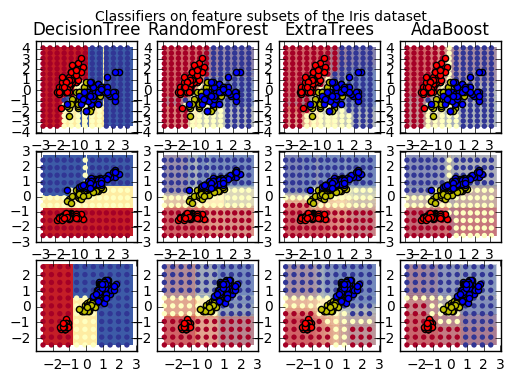

In [7]:
# As features são 0, 1, 2 ou 3. 
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # Usamos duas features de cada vez.
        X = iris.data[:, pair]
        # y contém os rótulos
        y = iris.target

        # Shuffle: embaralhar os índices dos dados
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Normalizar (?) os dados 
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = model.fit(X, y)

        scores = clf.score(X, y)

        # Criar um título para cada coluna dos gráficos
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print( model_details + " with features", pair, "has a score of", scores )

        # Criar a base para os gráficos
        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Adicionar o título a cada coluna
            plt.title(model_title)

        # Fazer o gráfico de cada região usando um contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plotar os dados de treinamento, com contorno preto
        for i, c in zip(range(0,n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()

Algumas referências: 
* http://blog.yhat.com/posts/random-forests-in-python.html
* http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/
* http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html